In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

# Part 1

To start, let's read in the data and plot it to get a sense of what we are working with. 

Map has shape: (4000, 6000)


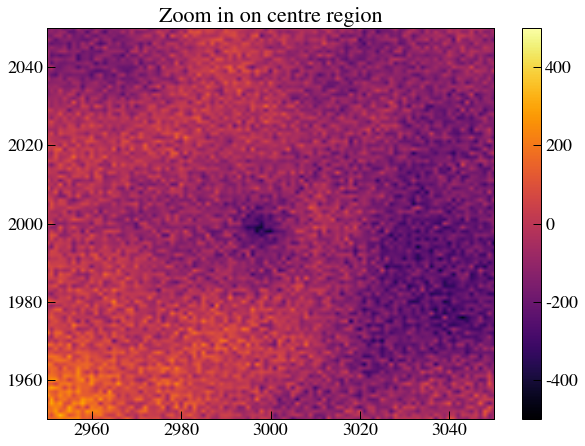

In [2]:
hdul = fits.open('advact_tt_patch.fits')
sky_map = np.asarray(hdul[0].data, dtype=np.float64)
hdul.close()

nrow = sky_map.shape[0]
ncol = sky_map.shape[1]

print('Map has shape:',sky_map.shape)
plt.figure(figsize=(10,7))
plt.imshow(sky_map, aspect='auto', vmin=-500, vmax=500)
plt.title('Zoom in on centre region')
plt.colorbar()
plt.xlim(2950, 3050)
plt.ylim(1950,2050)
plt.show()

Now that we have an idea of where the region is on the map, let's go ahead and fit a Gaussian to the cluster in the centre of the map. We'll follow a similar approach to how we did it in class. Note that I've taken the code Jon wrote in class and modified it to my needs wherever needed. 

In [3]:
def mygauss(pars,width):
    vec=np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    c = pars[4]

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp + c

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,Ninv,niter=10):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@Ninv@derivs
        rhs=derivs.T@(Ninv@resid)
        shift=np.linalg.inv(lhs)@rhs
        pars=pars+shift
    return pars

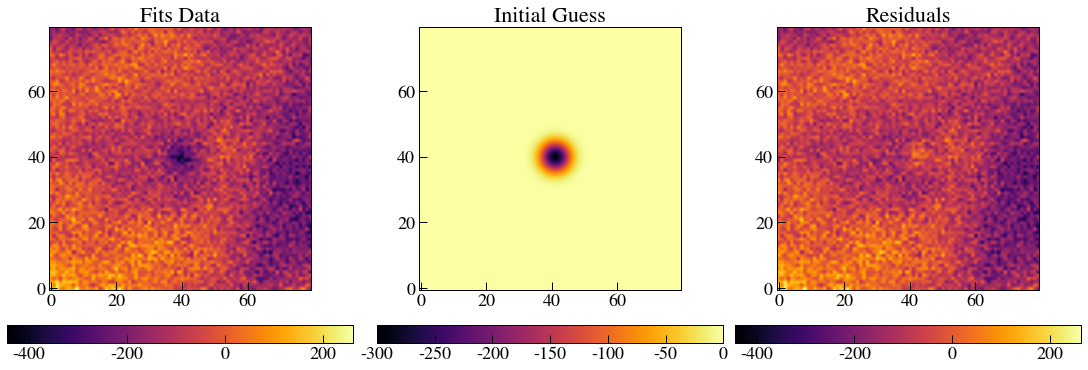

In [4]:
# Define initial parameters to carry out Newton best fit 
x0 = 1999
y0 = 2998
width = 40
map_use = sky_map[x0-width:x0+width,y0-width:y0+width]

pars_guess = np.asarray([-300, 0, 1, 3, 0], dtype=np.float64)
dpar = np.asarray([1.0, 0.01, 0.01, 0.01, 1])/10

model_guess = mygauss(pars_guess, width)
fig, axs = plt.subplots(1,3, figsize=(15,5), constrained_layout=True)
im0 = axs[0].imshow(map_use)
im2 = axs[2].imshow(map_use - model_guess)
im1 = axs[1].imshow(model_guess)
fig.colorbar(im0, ax=axs[0], location='bottom')
fig.colorbar(im1, ax=axs[1], location='bottom')
fig.colorbar(im2, ax=axs[2], location='bottom')
axs[0].set_title('Fits Data')
axs[1].set_title('Initial Guess')
axs[2].set_title('Residuals')
plt.show()



# Estimate noise matrix, assuming map noise is uniform and uncorrelated between map pixels
sig = np.std(map_use - model_guess)
Ninv = np.eye(map_use.shape[0]**2)/sig**2

Final chisq: 6336.482047045969
Fit parameters: [-185.63482552   -0.43441817   -0.72537029    5.15452029  -74.77850157]
Number of degrees of freedom: 6395


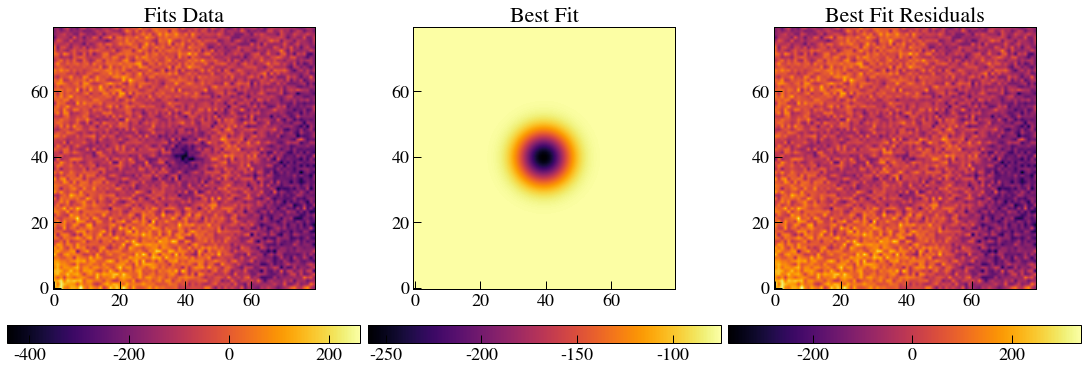

In [5]:
# Run fit algorithm 
fitp = newton(pars_guess, np.ravel(map_use), mygauss, width, dpar, Ninv, niter=20)
mymod = mygauss(fitp, width)

# Estimate noise using leftover noise after removing signal 
fit_chisq=np.sum((map_use-mymod)**2/sig**2)
print('Final chisq:', fit_chisq)
print('Fit parameters:', fitp)
print('Number of degrees of freedom:', mymod.size - pars_guess.size)

fig, axs = plt.subplots(1,3, figsize=(15,5), constrained_layout=True)
im0 = axs[0].imshow(map_use)
im2 = axs[2].imshow(map_use - mymod)
im1 = axs[1].imshow(mymod)
fig.colorbar(im0, ax=axs[0], location='bottom')
fig.colorbar(im1, ax=axs[1], location='bottom')
fig.colorbar(im2, ax=axs[2], location='bottom')
axs[0].set_title('Fits Data')
axs[1].set_title('Best Fit')
axs[2].set_title('Best Fit Residuals')
plt.show()

The best fit parameters are printed above. Note that I modified the model slightly by including an additional constant offset to distinguish the source from the background noise. Without it, Newton's method would constantly overestimate the width. Note that given the mean of $\chi^2$ is equal to the number of degrees of freedom (in this case 3595) with standard deviation ~60, our final chisq falls outside of the 1$\sigma$ region, but isn't terribly far off. However, a better estimate of the noise would definitely bring us closer. 

# Part 2

In [6]:
import importlib
import act_mf_tools
importlib.reload(act_mf_tools)
from act_mf_tools import get_gauss_kernel

In [7]:
def estimate_ps(vec, sig):    
    # Kernel is in Fourier space by default
    kernel = get_gauss_kernel(vec, sig, norm = True)
    
    kernel_ft = np.fft.fft2(kernel)
    
    # Get power spec
    ps = np.abs(np.fft.fft2(vec))**2
    
    ps_ft = np.fft.fft2(ps)
    
    # Convolve
    smoothed_ps = np.fft.ifft2(kernel_ft*ps_ft)
    
    npts = vec.size
    
    return np.real(smoothed_ps)

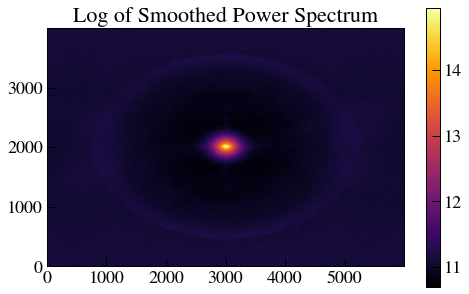

In [8]:
smoothed_ps = estimate_ps(sky_map, fitp[-2])

# Plot 2D power spec 
plt.figure(figsize=(8,5))
plt.title('Log of Smoothed Power Spectrum')
plt.imshow(np.fft.fftshift((np.log10(smoothed_ps))), aspect='equal')
plt.colorbar()
plt.show()

# Part 3

In [9]:
def pad_image(vec):
    mm=np.hstack([vec,np.fliplr(vec)])
    mm=np.vstack([mm,np.flipud(mm)])
    return mm

def unpad_image(padded_vec):
    nrow=padded_vec.shape[0]//2
    ncol=padded_vec.shape[1]//2
    return padded_vec[0:nrow,0:ncol]

def filter_map(vec, smoothed_ps):
    
    # Pad our arrays
    vec_padded = pad_image(vec)
    ps_padded = pad_image(smoothed_ps)
    
    npts = vec.size
    map_fft = np.fft.fft2(vec_padded)
    Ninv = 1/ps_padded

    # Calculate filtered map
    filtered_padded = np.real(np.fft.ifft2(map_fft*Ninv)) 
    
    # Unpad map
    filtered_map = unpad_image(filtered_padded) * npts
    
    return filtered_map


filtered_map = filter_map(sky_map, smoothed_ps)

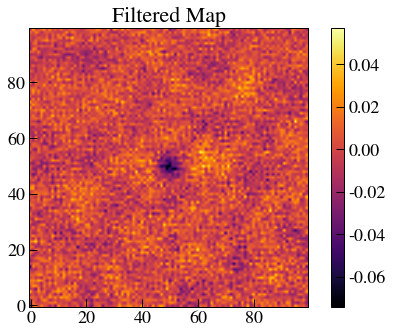

In [10]:
plt.figure(figsize=(8,5))
plt.imshow(filtered_map[x0-50:x0+50,y0-50:y0+50])
plt.colorbar()
plt.title('Filtered Map')
plt.show()


# Part 4

In [11]:
# Generate white noise 
_width = 1000
white_noise = np.random.normal(loc=0, scale=2, size=(_width,_width)) # Scale = sigma = standard deviation = 2. 
ps_white = estimate_ps(white_noise, sig = 50)
filtered_white = filter_map(white_noise, ps_white)
print('Variance:', np.var(filtered_white))

Variance: 0.24966891920751808


The above is consistent with what we would expect. Consider gaussian white noise with variance $\sigma^2 = 4$. The resulting power spectrum will have variance $\sigma_{ps}^2 = 16$ since it is squared of the Fourier transform. The filtered map is the Fourier transform of the white noise divided by the power spectrum, which will consequently have variance $\sigma_\text{filtered} = 4 / 16 = 1/4 = 0.25$, in agreement with what we see above. 

# Part 5

In [12]:
def xcorr(signal, model, noise_model):

    signal_ft = np.fft.fft2(signal)
    model_ft = np.fft.fft2(model)
    
    Ninv_model = model_ft / noise_model
    
    
    mf_rhs = np.real(np.fft.ifft2(Ninv_model*np.conj(signal_ft)))*signal.size
    mf_rhs_check = np.real(np.fft.ifft2(np.conj(signal_ft/noise_model)*model_ft))*signal.size
    
    lhs = np.real(np.fft.ifft2(Ninv_model))*signal.size
    
    return mf_rhs, mf_rhs_check, lhs

In [13]:
model = get_gauss_kernel(sky_map, fitp[-2])
noise_model = estimate_ps(sky_map, sig=50)
mf_rhs, mf_rhs_check, lhs = xcorr(sky_map, model, noise_model)

In [14]:
np.unique(np.isclose(mf_rhs, mf_rhs_check)) # Agree with 1e-8 tolerance, so confident that this is correct.

array([ True])

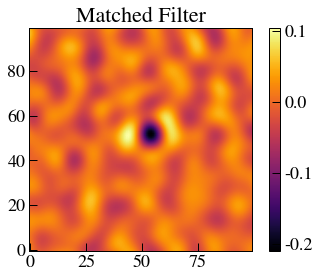

In [15]:
plt.imshow(mf_rhs[x0-50:x0+50,y0-50:y0+50])
plt.colorbar()
plt.title('Matched Filter')
plt.show()

In [34]:
# Get amplitudes 
amp = mf_rhs / np.sum(lhs) / 5 # Factor of 5 for 5 degrees of freedom
err = 1 / np.sqrt(np.sum(lhs))
std = np.std(amp[0:25, 0:25])

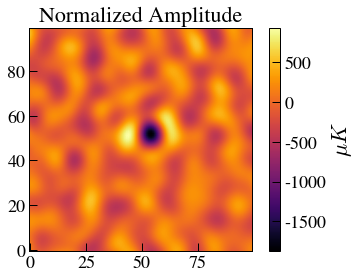

In [35]:
plt.imshow(amp[x0-50:x0+50,y0-50:y0+50])
plt.title('Normalized Amplitude')
cb = plt.colorbar()
cb.set_label('$\mu K$')

In [37]:
print('The amplitude of the cluster is: {0} μK'.format(amp[x0-50:x0+50,y0-50:y0+50].min()))
print(r'The error on the amplitude is: {0} μK'.format(err))
print('The standard deviation of the spread around the cluster is {0} μK'.format(std))

The amplitude of the cluster is: -1867.986976020356 μK
The error on the amplitude is: 211.1514421870579 μK
The standard deviation of the spread around the cluster is 235.6561139829341 μK


It is very possible that this is just a fluke that these are actually close to agreeing with one another, I did some pretty handwavey physics to get the amplitude and don't quite understand what is going on. That being said, it seems that the matched filter is working (though not properly normalized). 

# Part 6

Let's take a look at the output of the matched filter again, zooming in on a region suggested by Jon.

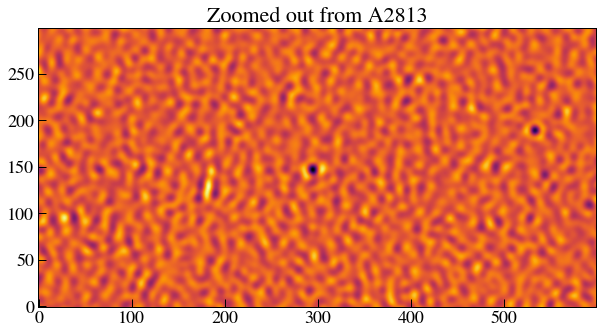

In [83]:
width = 300
mf_zoomout = mf_rhs[x0 - width//2:x0+width//2,y0-width:y0+width]
plt.figure(figsize=(10,5))
plt.imshow(mf_zoomout[::-1, ::-1], aspect='equal', origin='lower')
plt.title('Zoomed out from A2813')
plt.show()


We can clearly see another cluster roughly 240 pixels to the right and 40 pixels up of the central cluster. Assuming every pixel is 30 arcseconds, this corresponds to a change in RA of $\sim2$ degrees and change in DEC of $\sim0.35$ degrees. Since A2813 is located at an RA of 10.851 deg and DEC of -20.6214 deg, the new coordinates of this cluster are at (RA,DEC) ~ (8.876, -20.2714) deg. Searching the NED, I find that ACT-CL J0035.4-2015 (WHL J003526.2-201544) is the closest cluster, available [here](https://ned.ipac.caltech.edu/byname?objname=WHL+J003526.2-201544&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1). 